# **Used Car Price Predictor**

In [88]:
import warnings
warnings.filterwarnings("ignore")
import os 
import kaggle
import pandas as pd 
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from zlib import crc32
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats
import joblib

# **Import data from Kaggle**

We are using the "US Used cars dataset" from "https://www.kaggle.com/datasets/ananaymital/us-used-cars-dataset/data"

In [89]:
kaggleDataset = "ananaymital/us-used-cars-dataset"
datasetPath = os.path.join("dataset", "Used Cars")

In [90]:
# Check if the dataset folder already exists
if os.path.exists(datasetPath):
    download = input("The dataset may already be downloaded. Do you want to download and replace it? (Y/N): ").strip().upper()
    if download == 'Y':
        kaggle.api.dataset_download_files(kaggleDataset, datasetPath, unzip=True)
        print("Dataset downloaded and unzipped.")
    else:
        print("Skipping download.")
else:
    # Download if the dataset folder doesn't exist
    kaggle.api.dataset_download_files(kaggleDataset, datasetPath, unzip=True)
    print("Dataset downloaded and unzipped.")

Dataset URL: https://www.kaggle.com/datasets/ananaymital/us-used-cars-dataset
Dataset downloaded and unzipped.


In [91]:
def loadCarData(datasetPath = datasetPath):
    csvPath = os.path.join(datasetPath, "used_cars_data.csv")
    return pd.read_csv(csvPath, nrows=200000, engine='python', on_bad_lines='skip')

# **Examine quick info about the data structure**

In [92]:
carsFullLoad = loadCarData()
carsFullLoad = carsFullLoad[carsFullLoad["price"] > 0]
carsFullLoad.head()

,vin,back_legroom,bed,bed_height,bed_length,body_type,cabin,city,city_fuel_economy,combine_fuel_economy,...,transmission,transmission_display,trimId,trim_name,vehicle_damage_category,wheel_system,wheel_system_display,wheelbase,width,year
0,ZACNJABB5KPJ92081,35.1 in,NaN,NaN,NaN,SUV / Crossover,NaN,Bayamon,NaN,NaN,...,A,9-Speed Automatic Overdrive,t83804,Latitude FWD,NaN,FWD,Front-Wheel Drive,101.2 in,79.6 in,2019
1,SALCJ2FX1LH858117,38.1 in,NaN,NaN,NaN,SUV / Crossover,NaN,San Juan,NaN,NaN,...,A,9-Speed Automatic Overdrive,t86759,S AWD,NaN,AWD,All-Wheel Drive,107.9 in,85.6 in,2020
2,JF1VA2M67G9829723,35.4 in,NaN,NaN,NaN,Sedan,NaN,Guaynabo,17.0,NaN,...,M,6-Speed Manual,t58994,Base,NaN,AWD,All-Wheel Drive,104.3 in,78.9 in,2016
3,SALRR2RV0L2433391,37.6 in,NaN,NaN,NaN,SUV / Crossover,NaN,San Juan,NaN,NaN,...,A,8-Speed Automatic Overdrive,t86074,V6 HSE AWD,NaN,AWD,All-Wheel Drive,115 in,87.4 in,2020
4,SALCJ2FXXLH862327,38.1 in,NaN,NaN,NaN,SUV / Crossover,NaN,San Juan,NaN,NaN,...,A,9-Speed Automatic Overdrive,t86759,S AWD,NaN,AWD,All-Wheel Drive,107.9 in,85.6 in,2020


In [93]:
carsFullLoad["make_name"].unique()

array(['Jeep', 'Land Rover', 'Subaru', 'Mazda', 'Alfa Romeo', 'BMW',
       'Hyundai', 'Chevrolet', 'Lexus', 'Cadillac', 'Chrysler', 'Dodge',
       'Mercedes-Benz', 'Nissan', 'Honda', 'Kia', 'Ford', 'Lincoln',
       'Audi', 'Jaguar', 'Volkswagen', 'RAM', 'Porsche', 'Toyota',
       'INFINITI', 'GMC', 'Acura', 'Maserati', 'FIAT', 'Volvo',
       'Mitsubishi', 'Buick', 'Mercury', 'Scion', 'Saab', 'MINI',
       'Ferrari', 'Genesis', 'Saturn', 'Bentley', 'Suzuki', 'Tesla',
       'Fisker', 'Pontiac', 'Lamborghini', 'smart', 'Hummer',
       'Rolls-Royce', 'Lotus', 'Spyker', 'McLaren', 'Aston Martin',
       'Kaiser', 'Oldsmobile', 'Maybach', 'Freightliner', 'Karma',
       'Isuzu', 'Plymouth', 'Shelby', 'Triumph', 'MG', 'Pagani'],
      dtype=object)

To avoid outliers and keep the project more simple, let's only limit the makes of the car to below, which are common US car makes.

In [94]:
make_names = [
    "Jeep", "Chevrolet", "Cadillac", "Chrysler", "Dodge", "Ford", 
    "Lincoln", "RAM", "GMC", "Buick", "Tesla", "Hummer"
]

carsLoad = carsFullLoad[carsFullLoad["make_name"].isin(make_names)]

In [95]:
carsLoad["make_name"].unique()

array(['Jeep', 'Chevrolet', 'Cadillac', 'Chrysler', 'Dodge', 'Ford',
       'Lincoln', 'RAM', 'GMC', 'Buick', 'Tesla', 'Hummer'], dtype=object)

# **Initial information of our dataset**

In [96]:
carsLoad.info()

<class 'pandas.core.frame.DataFrame'>
Index: 88831 entries, 0 to 199993
Data columns (total 66 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   vin                      88831 non-null  object 
 1   back_legroom             85145 non-null  object 
 2   bed                      1010 non-null   object 
 3   bed_height               18552 non-null  object 
 4   bed_length               18552 non-null  object 
 5   body_type                88697 non-null  object 
 6   cabin                    2964 non-null   object 
 7   city                     88831 non-null  object 
 8   city_fuel_economy        71739 non-null  float64
 9   combine_fuel_economy     0 non-null      float64
 10  daysonmarket             88831 non-null  int64  
 11  dealer_zip               88831 non-null  object 
 12  description              85435 non-null  object 
 13  engine_cylinders         86120 non-null  object 
 14  engine_displacement      8

In [97]:
carsLoad.describe()

,city_fuel_economy,combine_fuel_economy,daysonmarket,engine_displacement,highway_fuel_economy,horsepower,is_certified,latitude,listing_id,longitude,mileage,owner_count,price,savings_amount,seller_rating,sp_id,vehicle_damage_category,year
count,71739.000000,0.0,88831.000000,84822.000000,71739.000000,84822.000000,0.0,88831.000000,8.883100e+04,88831.000000,83908.000000,42515.000000,88831.000000,88831.000000,88225.000000,88807.000000,0.0,88831.000000
mean,20.122430,NaN,86.684941,3255.246280,26.717908,272.688677,NaN,41.746348,2.745581e+08,-77.116010,30367.205022,1.476585,31177.716012,583.106371,4.231350,227540.306338,NaN,2017.691774
std,7.686896,NaN,121.247024,1484.060314,6.686650,88.194211,NaN,1.596100,9.958400e+06,6.686359,44489.578529,0.857975,15724.656139,1026.234083,0.502975,129622.256530,NaN,4.029634
min,9.000000,NaN,0.000000,1000.000000,12.000000,84.000000,NaN,18.398800,6.370622e+07,-157.902000,0.000000,1.000000,299.000000,0.000000,1.000000,41593.000000,NaN,1930.000000
25%,17.000000,NaN,18.000000,2000.000000,23.000000,180.000000,NaN,41.074000,2.735272e+08,-83.133000,5.000000,1.000000,19985.000000,0.000000,3.971014,61552.000000,NaN,2017.000000
50%,19.000000,NaN,41.000000,3200.000000,26.000000,281.000000,NaN,42.103200,2.780152e+08,-73.927500,7104.000000,1.000000,29160.000000,0.000000,4.307692,276888.000000,NaN,2020.000000
75%,22.000000,NaN,95.000000,3600.000000,29.000000,335.000000,NaN,42.561600,2.801414e+08,-72.358600,42906.000000,2.000000,40684.500000,846.000000,4.588235,328221.000000,NaN,2020.000000
max,127.000000,NaN,2624.000000,8400.000000,127.000000,808.000000,NaN,61.203100,2.816809e+08,-66.158200,785778.000000,15.000000,426450.000000,20460.000000,5.000000,440798.000000,NaN,2021.000000


# **Cleaning Our Data**

Let's make our dataset only with the columns that are not filled with many null values, and if it is a bit, we can replace the few null values with "No Input".

We will also convert some obvious numeric objects and dates to float types.

In [98]:
cars = carsLoad.loc[:, ["body_type", "daysonmarket", "engine_displacement", "engine_type", "franchise_dealer", "fuel_type", "horsepower", "is_new", "latitude", "listed_date", "listing_color", "listing_id", "longitude", "make_name", "model_name", "mileage", "price", "savings_amount", "seller_rating", "transmission", "trim_name", "wheel_system", "year"]]

for col in ['body_type', 'engine_type', 'fuel_type', 'transmission', "trim_name", 'wheel_system']:
    cars[col] = cars[col].fillna('No Input').str.lower()


for col in ['front_legroom', 'maximum_seating']:
    cars[col] = carsLoad[col].str.extract(r'(\d+(?:\.\d+)?)').astype(float)
    
cars['listed_dateTEMP'] = pd.to_datetime(carsLoad['listed_date']) 
cars['listed_date'] = cars['listed_dateTEMP'].astype('int64') / 1e9
cars.drop('listed_dateTEMP', axis=1, inplace=True)

In [99]:
cars.head()

,body_type,daysonmarket,engine_displacement,engine_type,franchise_dealer,fuel_type,horsepower,is_new,latitude,listed_date,...,mileage,price,savings_amount,seller_rating,transmission,trim_name,wheel_system,year,front_legroom,maximum_seating
0,suv / crossover,522,1300.0,i4,True,gasoline,177.0,True,18.3988,1.554509e+09,...,7.0,23141.0,0,2.800000,a,latitude fwd,fwd,2019,41.2,5.0
27,suv / crossover,522,1300.0,i4,True,gasoline,177.0,True,18.3988,1.554509e+09,...,20.0,27587.0,0,2.800000,a,latitude 4wd,4wd,2019,41.2,5.0
33,suv / crossover,522,1300.0,i4,True,gasoline,177.0,True,18.3988,1.554509e+09,...,7.0,27587.0,0,2.800000,a,latitude 4wd,4wd,2019,41.2,5.0
38,sedan,55,1500.0,i4,True,gasoline,160.0,False,40.7333,1.594858e+09,...,42394.0,14639.0,1749,3.447761,a,lt fwd,fwd,2018,42.0,5.0
41,suv / crossover,27,3600.0,v6,True,gasoline,310.0,False,40.7333,1.597277e+09,...,36410.0,23723.0,3500,3.447761,a,lt cloth fwd,fwd,2018,41.0,8.0


In [100]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
Index: 88831 entries, 0 to 199993
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   body_type            88831 non-null  object 
 1   daysonmarket         88831 non-null  int64  
 2   engine_displacement  84822 non-null  float64
 3   engine_type          88831 non-null  object 
 4   franchise_dealer     88831 non-null  bool   
 5   fuel_type            88831 non-null  object 
 6   horsepower           84822 non-null  float64
 7   is_new               88831 non-null  bool   
 8   latitude             88831 non-null  float64
 9   listed_date          88831 non-null  float64
 10  listing_color        88831 non-null  object 
 11  listing_id           88831 non-null  int64  
 12  longitude            88831 non-null  float64
 13  make_name            88831 non-null  object 
 14  model_name           88831 non-null  object 
 15  mileage              83908 non-null  flo

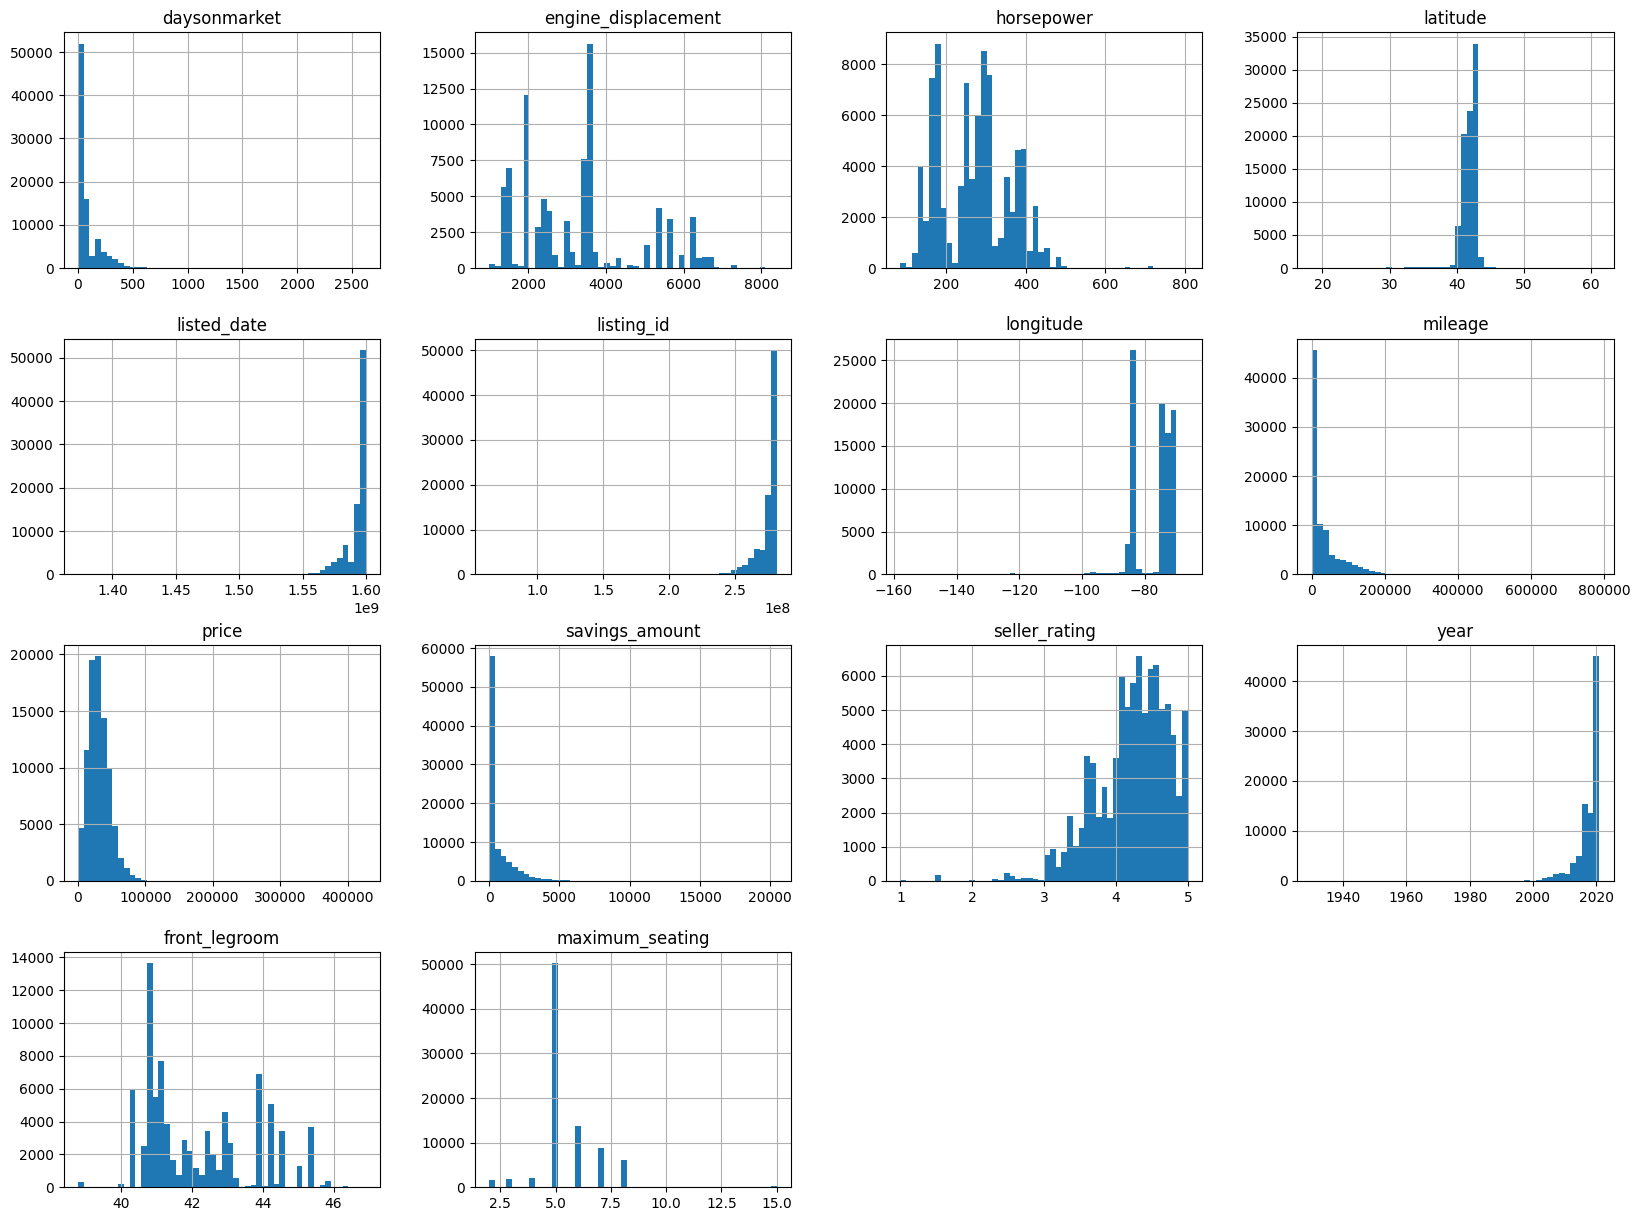

In [101]:
cars.hist(bins=50, figsize=(20,15))
plt.show()

Looking at some of these graphs, we can see some obvious unrealistic values that are skewing the graph. 

Let's find these outliers and filter them out.

In [102]:
max_daysonmarket = cars["daysonmarket"].max()
min_listed_date = cars["listed_date"].min()
min_listing_id = cars["listing_id"].min()
max_mileage = cars["mileage"].max()
max_price = cars["price"].max()
max_savings_amount = cars["savings_amount"].max()
min_year = cars["year"].min()
max_maximum_seating = cars["maximum_seating"].max()

print("Maximum daysonmarket:", max_daysonmarket)
print("Minimum listed_date:", min_listed_date)
print("Minimum listing_id:", min_listing_id)
print("Maximum mileage:", max_mileage)
print("Maximum price:", max_price)
print("Maximum savings_amount:", max_savings_amount)
print("Minimum year:", min_year)
print("Maximum maximum_seating:", max_maximum_seating)

Maximum daysonmarket: 2624
Minimum listed_date: 1372896000.0
Minimum listing_id: 63706221
Maximum mileage: 785778.0
Maximum price: 426450.0
Maximum savings_amount: 20460
Minimum year: 1930
Maximum maximum_seating: 15.0


In [103]:
cars = cars[(cars["daysonmarket"] <= 1000) & 
            (cars["listed_date"] >= 1500000000.0) & 
            (cars["listing_id"] >= 200000000) & 
            (cars["mileage"] <= 1000000) &
            (cars["price"] <= 300000) &
            (cars["savings_amount"] <= 20000) & 
            (cars["year"] >= 1990) & 
            (cars["maximum_seating"] <= 11)]

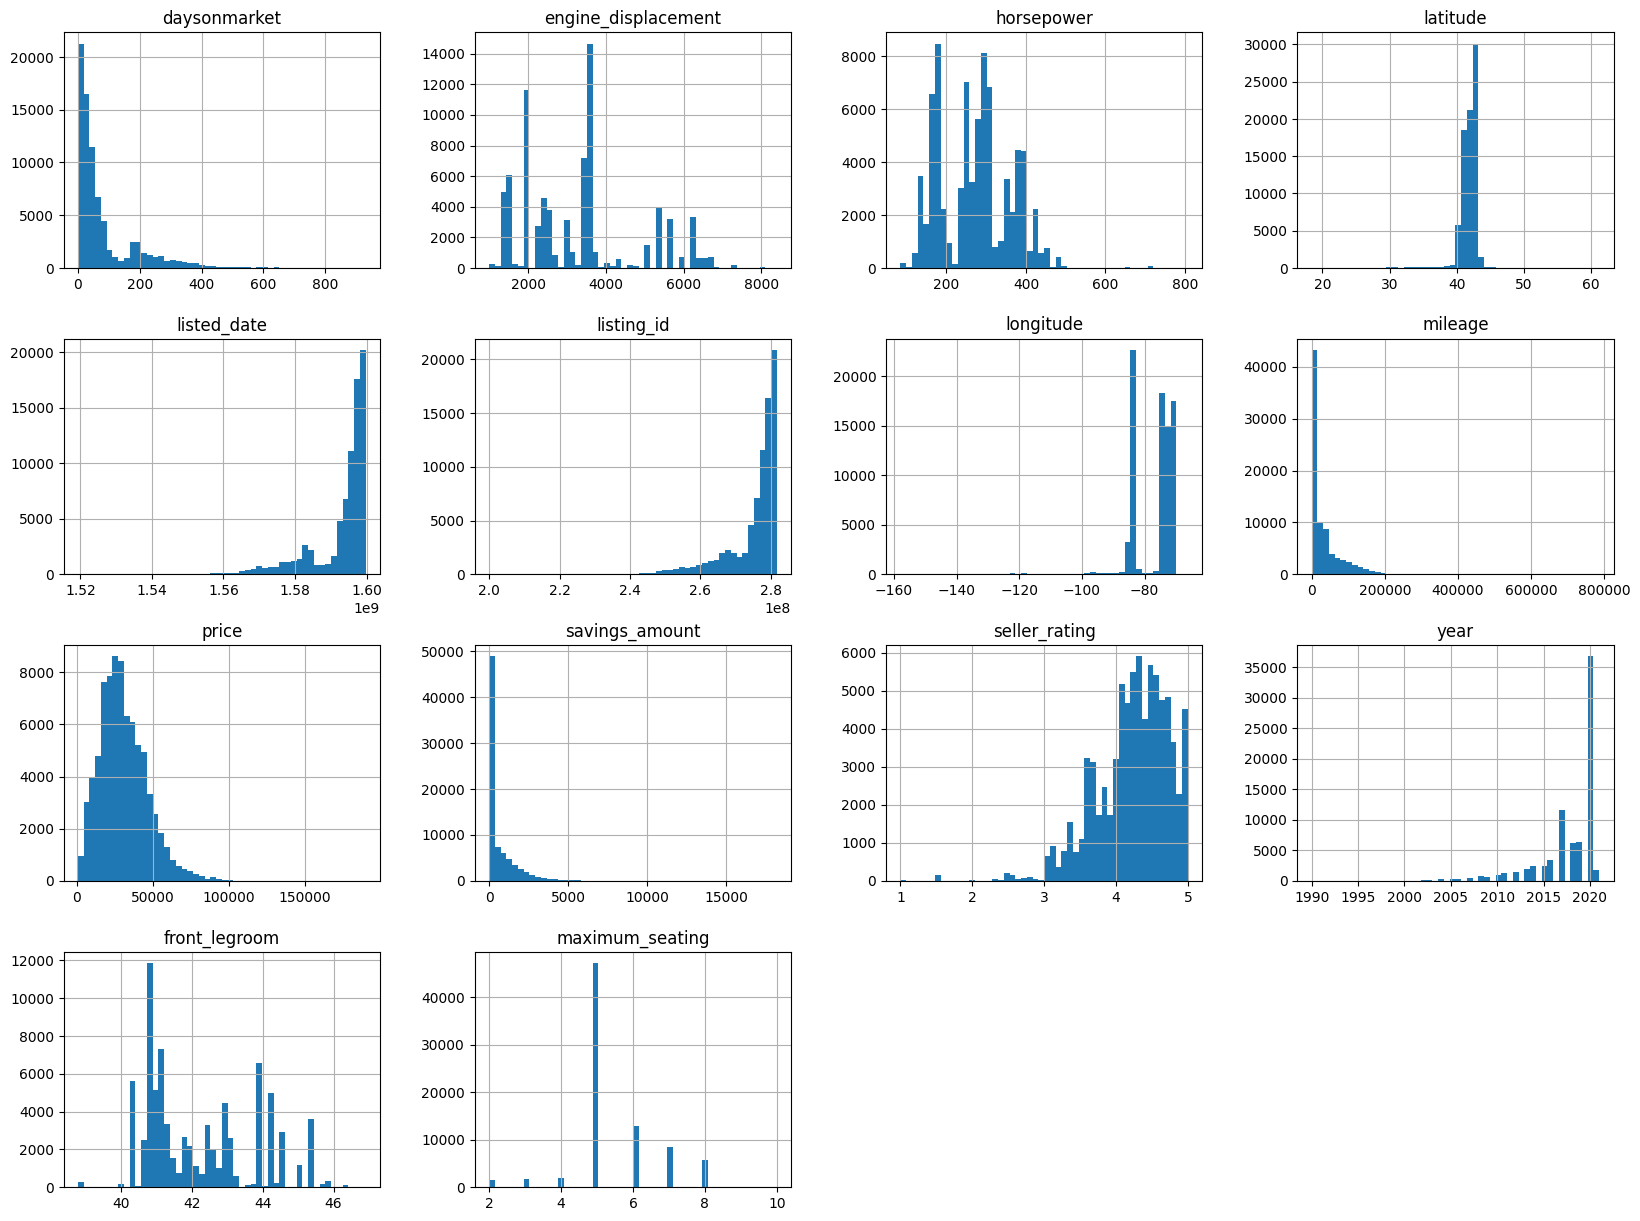

In [104]:
cars.hist(bins=50, figsize=(20,15))
plt.show()

In [105]:
max_daysonmarket = cars["daysonmarket"].max()
min_listed_date = cars["listed_date"].min()
min_listing_id = cars["listing_id"].min()
max_mileage = cars["mileage"].max()
max_price = cars["price"].max()
max_savings_amount = cars["savings_amount"].max()
min_year = cars["year"].min()
max_maximum_seating = cars["maximum_seating"].max()

print("Maximum daysonmarket:", max_daysonmarket)
print("Minimum listed_date:", min_listed_date)
print("Minimum listing_id:", min_listing_id)
print("Maximum mileage:", max_mileage)
print("Maximum price:", max_price)
print("Maximum savings_amount:", max_savings_amount)
print("Minimum year:", min_year)
print("Maximum maximum_seating:", max_maximum_seating)

Maximum daysonmarket: 931
Minimum listed_date: 1519344000.0
Minimum listing_id: 200021460
Maximum mileage: 785778.0
Maximum price: 189935.0
Maximum savings_amount: 18188
Minimum year: 1990
Maximum maximum_seating: 10.0


### Let's make a new column grouping `price`, this will come in handy later to ensure our test set is not running into sampling bias. 

In [106]:
cars["price_group"] = pd.cut(cars["price"],
                            bins=[0., 10000., 20000.,30000., 40000., 50000., np.inf],
                            labels=[1, 2, 3, 4, 5, 6])

<Axes: >

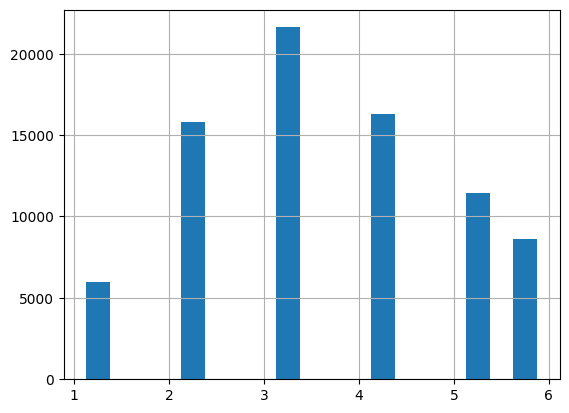

In [107]:
cars["price_group"].hist(rwidth=0.5)

In [108]:
cars["price_group"].value_counts() / len(cars)

price_group
3    0.271057
4    0.204656
2    0.198300
5    0.143144
6    0.107793
1    0.075050
Name: count, dtype: float64

# **Creating our Train and Test Set**

In order to ensure that our test set stays consistent no matter how many times we rerun the program or update the dataset, we want to use a unique identifier to help us decide if the row should go into the test set or not. We can compute a hash for each row's unique identifier and if it is less than or equal to 20% of the maximum hash value, it will go into the test set. 

In [109]:
cars = cars.drop_duplicates(subset="listing_id", keep="first")

In [110]:
len(cars) - len(cars["listing_id"].unique()) # Making sure "listing_id" is unique, this should be zero if true

0

In [111]:
def IDTest(ID, testRatio):
    return crc32(np.int64(ID)) & 0xffffffff < testRatio*2**32

def splitTrainTestByID(dataset,testRatio,ID):
    IDs = dataset[ID]
    testRows = IDs.apply(lambda ID_: IDTest(ID_, testRatio))
    return dataset.loc[~testRows], dataset.loc[testRows]

In [112]:
trainSet, testSet = splitTrainTestByID(cars, 0.2, "listing_id")

In [113]:
len(trainSet) / len(cars) # training set should be 80%

0.8008850112193349

In [114]:
len(testSet) / len(cars) # training set should be 20%

0.19911498878066514

Let's compare our test set's price group proportions to the overall price group proportions.

In [115]:
(testSet["price_group"].value_counts() / len(testSet)) - (cars["price_group"].value_counts() / len(cars))


price_group
3   -0.003744
4    0.002156
2    0.001020
5    0.000901
6    0.001247
1   -0.001580
Name: count, dtype: float64

The proportions of the price groups in our test set are nearly identical to the overall proportions. 
Therefore, it is not necessary to try and do stratified sampling. 

We can now be confident that our test set is a good representation of the overall dataset.
We can remove the priceGroup column. 
We can also remove listing_id as we do not want the model to make predictions with it.

In [116]:
for set_ in (trainSet, testSet):
    set_.drop(columns=["price_group", "listing_id"], inplace=True)

# **Visualizing Data**
Now we can play with our train set, first let's start with visualizing the data

<Axes: xlabel='longitude', ylabel='latitude'>

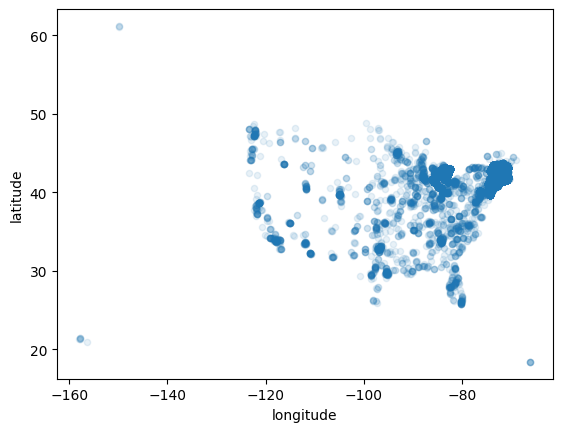

In [117]:
trainSet.plot.scatter(x="longitude", y="latitude", alpha=0.1)

<Axes: xlabel='mileage', ylabel='daysonmarket'>

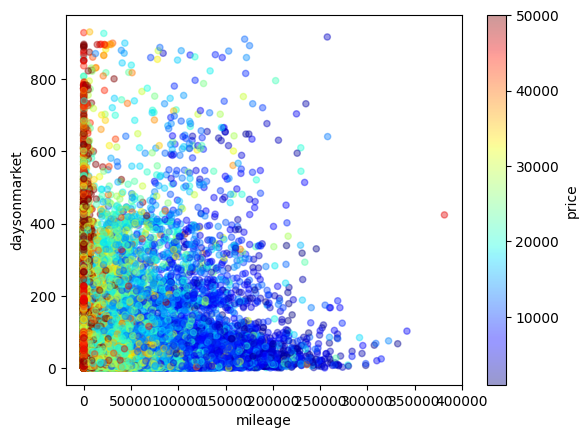

In [118]:
trainSet.plot.scatter(x="mileage", y="daysonmarket", alpha=0.4,
                  c="price", cmap=plt.get_cmap("jet"), colorbar=True,
                  vmin=1000, vmax=50000)

In [119]:
trainSet.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63889 entries, 0 to 199992
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   body_type            63889 non-null  object 
 1   daysonmarket         63889 non-null  int64  
 2   engine_displacement  63509 non-null  float64
 3   engine_type          63889 non-null  object 
 4   franchise_dealer     63889 non-null  bool   
 5   fuel_type            63889 non-null  object 
 6   horsepower           63509 non-null  float64
 7   is_new               63889 non-null  bool   
 8   latitude             63889 non-null  float64
 9   listed_date          63889 non-null  float64
 10  listing_color        63889 non-null  object 
 11  longitude            63889 non-null  float64
 12  make_name            63889 non-null  object 
 13  model_name           63889 non-null  object 
 14  mileage              63889 non-null  float64
 15  price                63889 non-null  flo

Let's start looking at correlations and visualize it.

In [120]:
train_numeric_attribs = trainSet.select_dtypes(include=['float64', 'int64'])
corr_matrix = train_numeric_attribs.corr()

In [121]:
corr_matrix["price"].sort_values(ascending=False)

price                  1.000000
horsepower             0.605919
year                   0.590623
engine_displacement    0.365962
front_legroom          0.290727
maximum_seating        0.276524
daysonmarket           0.103292
longitude              0.071668
seller_rating          0.052043
latitude               0.029986
listed_date           -0.104625
savings_amount        -0.193517
mileage               -0.596498
Name: price, dtype: float64

array([[<Axes: xlabel='price', ylabel='price'>,
        <Axes: xlabel='horsepower', ylabel='price'>,
        <Axes: xlabel='year', ylabel='price'>,
        <Axes: xlabel='mileage', ylabel='price'>],
       [<Axes: xlabel='price', ylabel='horsepower'>,
        <Axes: xlabel='horsepower', ylabel='horsepower'>,
        <Axes: xlabel='year', ylabel='horsepower'>,
        <Axes: xlabel='mileage', ylabel='horsepower'>],
       [<Axes: xlabel='price', ylabel='year'>,
        <Axes: xlabel='horsepower', ylabel='year'>,
        <Axes: xlabel='year', ylabel='year'>,
        <Axes: xlabel='mileage', ylabel='year'>],
       [<Axes: xlabel='price', ylabel='mileage'>,
        <Axes: xlabel='horsepower', ylabel='mileage'>,
        <Axes: xlabel='year', ylabel='mileage'>,
        <Axes: xlabel='mileage', ylabel='mileage'>]], dtype=object)

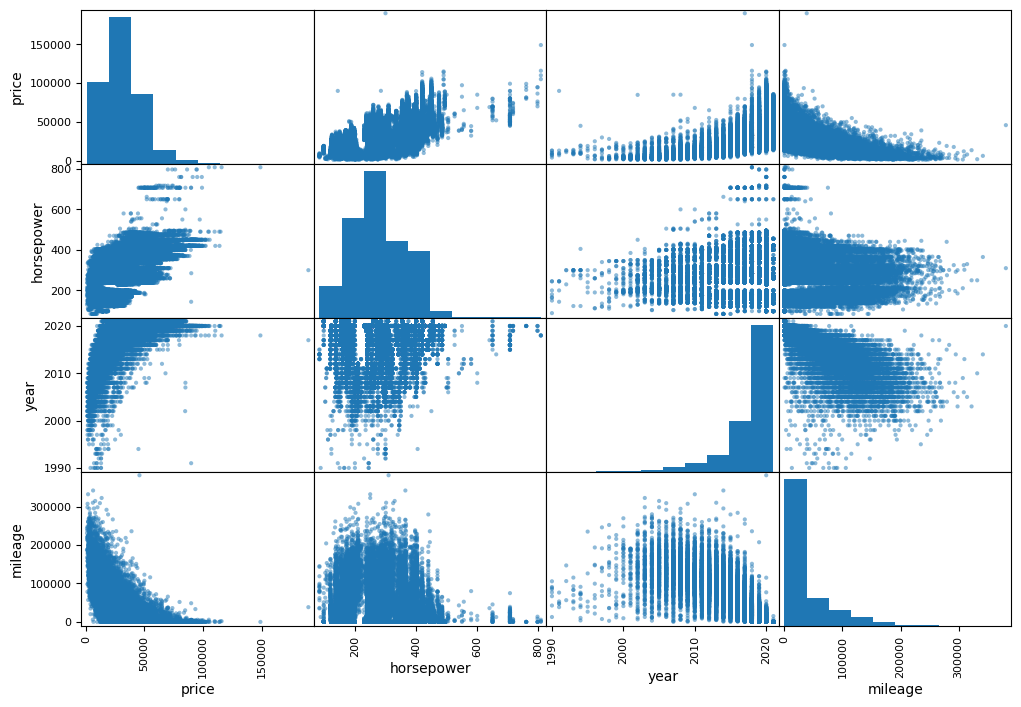

In [122]:
matrix_attributes = ["price", "horsepower", "year", "mileage"]
scatter_matrix(trainSet[matrix_attributes], figsize=(12,8))

# **Data Imputation**

For our transformation pipeline, we will need it to do some data imputation. Some of our float type columns still have some null values. We can replace all null values with the median of the attribute.

To be on the safer side, let's use Scikit-Learn's SimpleImputer class to replace all null values with the median to all numerical columns. Let's see how it will do before creating our pipeline.

In [123]:
X_train = trainSet.drop("price", axis=1)
y_train = trainSet["price"].copy()

In [124]:
X_train_numeric_attribs = X_train.select_dtypes(include=['float64', 'int64'])

imputer = SimpleImputer(strategy="median")
imputer.fit(X_train_numeric_attribs)

SimpleImputer(strategy='median')

In [125]:
imputer.statistics_

array([ 4.00000000e+01,  3.20000000e+03,  2.81000000e+02,  4.21027000e+01,
        1.59615360e+09, -7.39197000e+01,  7.77000000e+03,  0.00000000e+00,
        4.30769231e+00,  2.01900000e+03,  4.18000000e+01,  5.00000000e+00])

In [126]:
X_train_numeric_attribs.median().values

array([ 4.00000000e+01,  3.20000000e+03,  2.81000000e+02,  4.21027000e+01,
        1.59615360e+09, -7.39197000e+01,  7.77000000e+03,  0.00000000e+00,
        4.30769231e+00,  2.01900000e+03,  4.18000000e+01,  5.00000000e+00])

# **Categorical Data Preprocessing**

In our pipeline, we want to change the bool columns, "is_new" and "franchise_dealer", to a numeric value using OrdinalEncoder. Let's see how it works.

In [127]:
X_train_bool_attribs = X_train.select_dtypes(include=['bool'])
ordinal_encoder = OrdinalEncoder()
X_train_bool_attribs_encoded = ordinal_encoder.fit_transform(X_train_bool_attribs)
X_train_bool_attribs_encoded[:10]

array([[1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])

For our pipeline, we also want to change the categorical columns to a numeric value. For this we can use OneHotEncoder. Let's see how it is.

In [128]:
X_train_object_attribs = X_train.select_dtypes(include=['object'])
object_encoder = OneHotEncoder()
X_train_object_attribs_1hot = object_encoder.fit_transform(X_train_object_attribs)
X_train_object_attribs_1hot

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 575001 stored elements and shape (63889, 1849)>

In [129]:
X_train_object_attribs_1hot.toarray()

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [130]:
object_encoder.categories_

[array(['convertible', 'coupe', 'hatchback', 'minivan', 'pickup truck',
        'sedan', 'suv / crossover', 'van', 'wagon'], dtype=object),
 array(['i3', 'i4', 'i4 diesel', 'i4 flex fuel vehicle', 'i4 hybrid', 'i5',
        'i5 biodiesel', 'i6', 'i6 diesel', 'no input', 'v10', 'v6',
        'v6 biodiesel', 'v6 diesel', 'v6 flex fuel vehicle', 'v6 hybrid',
        'v8', 'v8 biodiesel', 'v8 compressed natural gas', 'v8 diesel',
        'v8 flex fuel vehicle', 'v8 hybrid'], dtype=object),
 array(['biodiesel', 'compressed natural gas', 'diesel',
        'flex fuel vehicle', 'gasoline', 'hybrid', 'no input'],
       dtype=object),
 array(['BLACK', 'BLUE', 'BROWN', 'GOLD', 'GRAY', 'GREEN', 'ORANGE',
        'PURPLE', 'RED', 'SILVER', 'TEAL', 'UNKNOWN', 'WHITE', 'YELLOW'],
       dtype=object),
 array(['Buick', 'Cadillac', 'Chevrolet', 'Chrysler', 'Dodge', 'Ford',
        'GMC', 'Hummer', 'Jeep', 'Lincoln', 'RAM'], dtype=object),
 array(['1500', '200', '2500', '300', '300M', '3500', '3500 Cha

# **Transformation Pipeline**

Now we can start building our transformation pipelines.

Let's make a numerical pipeline first for our numeric columns. We will replace all null values with the median values, and also use StandardScaler() to scale all columns.

In [131]:
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

X_train_numeric_transformed = numeric_pipeline.fit_transform(X_train_numeric_attribs)

Now we can make our full pipeline, where we use the numeric_pipeline for our numerical columns, Ordinalencoder() for our bool columns, and OneHotEncoder() for our object columns. 

In [132]:
numeric_attribs = list(X_train_numeric_attribs)
bool_attribs = list(X_train_bool_attribs)
object_attribs = list(X_train_object_attribs)

full_pipeline = ColumnTransformer([
    ('numeric', numeric_pipeline, numeric_attribs),
    ('bool', OrdinalEncoder(), bool_attribs),
    ('objects', OneHotEncoder(handle_unknown='ignore'), object_attribs), 
])

In [133]:
X_train_prepared = full_pipeline.fit_transform(X_train)

We now have prepared our training set for training. 

# **Selecting and Training a Model**

# **1) Linear Regression Model**

We will first try to train the model using a Linear Regression Model

In [134]:
train_lin_reg = LinearRegression()
train_lin_reg.fit(X_train_prepared, y_train)

LinearRegression()

We can get a small sample of how it does with some data from the training set itself.

In [135]:
some_data = X_train.iloc[:5]
some_labels = y_train.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", train_lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [29083.5333415  31044.35475168 30948.77143515 15944.65448163
 24329.97765957]
Labels: [23141.0, 27587.0, 27587.0, 14639.0, 23723.0]


In [136]:
train_lin_reg_predictions = train_lin_reg.predict(X_train_prepared)

### Let's create functions that will print out our results.

In [137]:
def CalcAndPrintMetrics(predictions, y, model_name="Model"):
    mse = mean_squared_error(y, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, predictions)
    r2 = r2_score(y, predictions)
    mape = np.mean(np.abs((y - predictions) / y)) * 100  

    print(f"{model_name} Evaluation Metrics")
    print(f"{model_name} Root Mean Squared Error (RMSE):", rmse)
    print(f"{model_name} Mean Absolute Error (MAE):", mae)
    print(f"{model_name} R² Score:", r2)
    print(f"{model_name} Mean Absolute Percentage Error (MAPE):", mape, "%")

In [138]:
CalcAndPrintMetrics(train_lin_reg_predictions, y_train, "Linear Regression")

Linear Regression Evaluation Metrics
Linear Regression Root Mean Squared Error (RMSE): 3815.217464035993
Linear Regression Mean Absolute Error (MAE): 2746.7973692285254
Linear Regression R² Score: 0.9397508339656353
Linear Regression Mean Absolute Percentage Error (MAPE): 12.240326255054558 %


### Let's use cross-validation to get a better picture of our results.

In [139]:
train_lin_reg_CV_scores = cross_val_score(train_lin_reg, X_train_prepared, y_train, scoring="neg_mean_squared_error", cv=3)

In [140]:
def CalcAndPrintCVScores(cv_scores, model_name="Model"):
    cv_rmse_scores = np.sqrt(-cv_scores)
    
    print(f"\n{model_name} Cross-Validation Metrics")
    print(f"{model_name} Cross-Validation RMSE Scores:", cv_rmse_scores)
    print(f"{model_name} Mean Cross-Validation RMSE:", cv_rmse_scores.mean())
    print(f"{model_name} Cross-Validation RMSE Standard Deviation:", cv_rmse_scores.std())

In [141]:
CalcAndPrintCVScores(train_lin_reg_CV_scores, "Linear Regression")


Linear Regression Cross-Validation Metrics
Linear Regression Cross-Validation RMSE Scores: [4490.37068139 4018.13076579 4197.5719822 ]
Linear Regression Mean Cross-Validation RMSE: 4235.357809790963
Linear Regression Cross-Validation RMSE Standard Deviation: 194.63377755237528


# **2) Decision Tree Regression**

In [142]:
from sklearn.tree import DecisionTreeRegressor

train_tree_reg = DecisionTreeRegressor()
train_tree_reg.fit(X_train_prepared, y_train)

DecisionTreeRegressor()

In [143]:
train_tree_reg_predictions = train_tree_reg.predict(X_train_prepared)

In [144]:
CalcAndPrintMetrics(train_tree_reg_predictions, y_train, "Decision Tree Regression")

Decision Tree Regression Evaluation Metrics
Decision Tree Regression Root Mean Squared Error (RMSE): 221.42540776232656
Decision Tree Regression Mean Absolute Error (MAE): 26.017597917743252
Decision Tree Regression R² Score: 0.9997970601424253
Decision Tree Regression Mean Absolute Percentage Error (MAPE): 0.07208230010656162 %


In [145]:
train_tree_reg_CV_scores = cross_val_score(train_tree_reg, X_train_prepared, y_train, scoring="neg_mean_squared_error", cv=3)

In [146]:
CalcAndPrintCVScores(train_tree_reg_CV_scores, "Decision Tree Regression")


Decision Tree Regression Cross-Validation Metrics
Decision Tree Regression Cross-Validation RMSE Scores: [4849.88127562 4569.93561291 4783.77130183]
Decision Tree Regression Mean Cross-Validation RMSE: 4734.529396786828
Decision Tree Regression Cross-Validation RMSE Standard Deviation: 119.47375563237455


# **3) Random Forest Regression**

In [147]:
from sklearn.ensemble import RandomForestRegressor

train_forest_reg = RandomForestRegressor()
train_forest_reg.fit(X_train_prepared, y_train)

RandomForestRegressor()

In [148]:
train_forest_reg_predictions = train_forest_reg.predict(X_train_prepared)

In [149]:
CalcAndPrintMetrics(train_forest_reg_predictions, y_train, "Random Forest Regression")

Random Forest Regression Evaluation Metrics
Random Forest Regression Root Mean Squared Error (RMSE): 976.0887668048755
Random Forest Regression Mean Absolute Error (MAE): 580.0893983516171
Random Forest Regression R² Score: 0.9960564161938749
Random Forest Regression Mean Absolute Percentage Error (MAPE): 2.3912462289862777 %


In [150]:
train_forest_reg_CV_scores = cross_val_score(train_forest_reg, X_train_prepared, y_train, scoring="neg_mean_squared_error", cv=3)

In [151]:
CalcAndPrintCVScores(train_forest_reg_CV_scores, "Random Forest Regression")


Random Forest Regression Cross-Validation Metrics
Random Forest Regression Cross-Validation RMSE Scores: [3715.04824129 3398.21462272 3551.32345172]
Random Forest Regression Mean Cross-Validation RMSE: 3554.862105243035
Random Forest Regression Cross-Validation RMSE Standard Deviation: 129.37098339145214


#### These metrics gives us an interesting result between the Decision Tree and the Random Forest models. The Decision Tree model first had a RMSE of **69**, while the Random Forest had **966**. This could give us the idea that the Decision Tree model is performing significantly better than the Random Forest model. However, the mean Cross-Validation RMSE results tells us differently. The Decision Tree model had a mean Cross-Validation RMSE of **4,399**, while the Random Forest had **3,281**.

#### This discrepancy suggests that the Decision Tree model may be **overfitting** to the training data, as it achieves a very low RMSE on the complete training set but performs worse during cross-validation. The Random Forest model, while having a higher initial RMSE on the complete training data, shows more stable and reliable performance across folds in cross-validation.

#### In summary, the Random Forest model’s lower mean Cross-Validation RMSE indicates it generalizes better to new data and is likely the more robust model overall more than the Decision Tree model. This highlights the importance of cross-validation in evaluating a model’s performance and avoiding misleading conclusions from training results alone.

# **Fine Tuning Random Forest Using RandomizedSearchCV**

Let's do some hyperparameter tuning on the RandomForestRegressor using RandomizedSearchCV.

In [152]:
param_grid = [
    {
    'n_estimators': [100, 200, 300, 400],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30, 40],  # Maximum depth of each tree
    'min_samples_split': [2, 4, 5],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required at a leaf node
    'max_features': ['auto', 'sqrt'],  # Number of features considered for each split
    'bootstrap': [True]  # Whether samples are drawn with replacement
    }
]

train_forest_reg_tuned = RandomForestRegressor()

Randomized_search = RandomizedSearchCV(
                                    train_forest_reg_tuned, 
                                    param_grid, 
                                    n_iter=25, 
                                    cv=3,
                                    scoring='neg_mean_squared_error',
                                    n_jobs=-1,
                                    refit=True,
                                    verbose=1,
                                    return_train_score=True)

Randomized_search.fit(X_train_prepared, y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=25,
                   n_jobs=-1,
                   param_distributions=[{'bootstrap': [True],
                                         'max_depth': [None, 10, 20, 30, 40],
                                         'max_features': ['auto', 'sqrt'],
                                         'min_samples_leaf': [1, 2, 4],
                                         'min_samples_split': [2, 4, 5],
                                         'n_estimators': [100, 200, 300, 400]}],
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=1)

Let's view what was the best hperparameters and estimators in our RandomizedSearchCV

In [153]:
Randomized_search.best_params_

{'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': True}

In [154]:
Randomized_search.best_estimator_

RandomForestRegressor(max_features='sqrt', min_samples_split=5)

Let's view the RMSE for each tested parameter set, and we should see `{'n_estimators': 400, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': False}` being the lowest.

In [155]:
cvres = Randomized_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

nan {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 20, 'bootstrap': True}
nan {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 20, 'bootstrap': True}
nan {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}
nan {'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 20, 'bootstrap': True}
8880.483711762952 {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}
nan {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}
nan {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 30, 'bootstrap': True}
3900.027306248476 {'n_estimators': 100, 'min_sample

Let's get the feature importances from our best model found, and after creating our complete feature list, we can sort and display feature importances from most to least influential

In [156]:
feature_importances = Randomized_search.best_estimator_.feature_importances_
feature_importances

array([0.0107614 , 0.04196433, 0.09454743, ..., 0.02366875, 0.00020416,
       0.00154852])

In [157]:
object_encoder = full_pipeline.named_transformers_["objects"]
object_one_hot_attribs = np.concatenate(object_encoder.categories_)
object_attribs = list(object_one_hot_attribs)
attributes = numeric_attribs + bool_attribs + object_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(np.float64(0.09454742710153036), 'horsepower'),
 (np.float64(0.09259260719571034), 'mileage'),
 (np.float64(0.08387572141028848), 'year'),
 (np.float64(0.0663445151921103), 'savings_amount'),
 (np.float64(0.05347862987630417), 'is_new'),
 (np.float64(0.04767364990986702), 'front_legroom'),
 (np.float64(0.04196433104014416), 'engine_displacement'),
 (np.float64(0.0366354799364964), 'maximum_seating'),
 (np.float64(0.0323458126861148), 'franchise_dealer'),
 (np.float64(0.02366874971388084), 'fwd'),
 (np.float64(0.023373055820563343), '4wd'),
 (np.float64(0.01563336942468535), 'v8'),
 (np.float64(0.015212780113877906), 'i4'),
 (np.float64(0.012095757610238402), 'pickup truck'),
 (np.float64(0.011001562205902647), 'longitude'),
 (np.float64(0.010761403619253882), 'daysonmarket'),
 (np.float64(0.01050994736594708), 'Lincoln'),
 (np.float64(0.010480987513337472), 'latitude'),
 (np.float64(0.01035994623625669), 'listed_date'),
 (np.float64(0.009784116639811942), 'seller_rating'),
 (np.float

### We can see that the most influential feature in our best model is the `year` column, followed by `horsepower`, and so on.

# **Testing Our Model**

Let's make the fine-tuned Random Forest by RandomizedSearchCV model as our final model for testing and print the RMSE

In [158]:
X_test = testSet.drop("price", axis = 1)
y_test = testSet["price"].copy()

X_test_prepared = full_pipeline.transform(X_test)

In [159]:
final_model = Randomized_search.best_estimator_

final_model_predictions = final_model.predict(X_test_prepared)

In [160]:
CalcAndPrintMetrics(final_model_predictions, y_test, "Final Model (Fined Tuned Random Forest by RandomizedSearchCV)")

Final Model (Fined Tuned Random Forest by RandomizedSearchCV) Evaluation Metrics
Final Model (Fined Tuned Random Forest by RandomizedSearchCV) Root Mean Squared Error (RMSE): 3002.8805648707116
Final Model (Fined Tuned Random Forest by RandomizedSearchCV) Mean Absolute Error (MAE): 2016.5177690568125
Final Model (Fined Tuned Random Forest by RandomizedSearchCV) R² Score: 0.9621902715773315
Final Model (Fined Tuned Random Forest by RandomizedSearchCV) Mean Absolute Percentage Error (MAPE): 9.494951509933266 %


In [161]:
final_model_CV_scores = cross_val_score(final_model, X_test_prepared, y_test, scoring="neg_mean_squared_error", cv=10)

In [162]:
CalcAndPrintCVScores(final_model_CV_scores, "Final Model (Fined Tuned Random Forest by RandomizedSearchCV)")


Final Model (Fined Tuned Random Forest by RandomizedSearchCV) Cross-Validation Metrics
Final Model (Fined Tuned Random Forest by RandomizedSearchCV) Cross-Validation RMSE Scores: [4296.88616555 4100.26998252 4512.7062528  4121.93534117 4257.7096061
 3748.84979746 4160.75020792 3885.74602254 4161.05393882 4844.02360113]
Final Model (Fined Tuned Random Forest by RandomizedSearchCV) Mean Cross-Validation RMSE: 4208.993091600323
Final Model (Fined Tuned Random Forest by RandomizedSearchCV) Cross-Validation RMSE Standard Deviation: 290.83496126037784


Let's get the squared errors of each prediction, so we can better understand the RMSE by getting a 95% confidence interval and 10 samples.

In [163]:
final_model_squared_errors = (final_model_predictions - y_test) ** 2

print("Final Model (Fined Tuned Random Forest by RandomizedSearchCV) Mean Squared Error:", final_model_squared_errors.mean())
print("Final Model (Fined Tuned Random Forest by RandomizedSearchCV) Standard Error of Mean:", stats.sem(final_model_squared_errors))

Final Model (Fined Tuned Random Forest by RandomizedSearchCV) Mean Squared Error: 9017291.686878245
Final Model (Fined Tuned Random Forest by RandomizedSearchCV) Standard Error of Mean: 395519.47986249416


In [164]:
df_final_model_squared_errors = pd.DataFrame({'Predictions': final_model_predictions, 'Actual': y_test, 'Squared Errors': final_model_squared_errors})
print(df_final_model_squared_errors.head(10)) 

      Predictions   Actual  Squared Errors
81   34558.248292  34224.0    1.117219e+05
85   26535.645437  23300.0    1.046940e+07
91   15865.038940  12924.0    8.649710e+06
96   21330.212433  18959.0    5.622648e+06
98   50940.031845  57000.0    3.672321e+07
133  16140.261845  15724.0    1.732739e+05
141  26677.361393  27200.0    2.731511e+05
148  28287.303585  27300.0    9.747684e+05
173  35356.810460  32439.0    8.513618e+06
185  27365.037718  25272.0    4.380807e+06


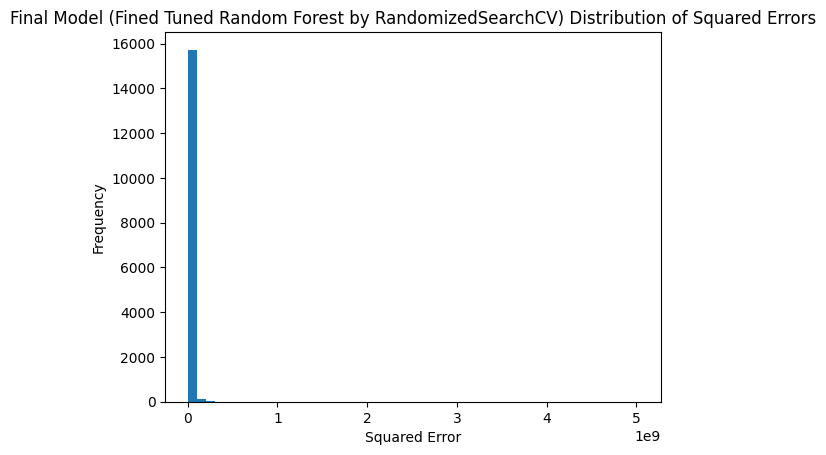

In [165]:
plt.hist(final_model_squared_errors, bins=50)
plt.title('Final Model (Fined Tuned Random Forest by RandomizedSearchCV) Distribution of Squared Errors')
plt.xlabel('Squared Error')
plt.ylabel('Frequency')
plt.show()

Let's view our biggest errors by getting our top 1% outliers of our squared errors.

In [166]:
outliers = df_final_model_squared_errors[df_final_model_squared_errors['Squared Errors'] > df_final_model_squared_errors['Squared Errors'].quantile(0.99)] 
print(outliers)

         Predictions   Actual  Squared Errors
775     42776.681159  53939.0    1.245974e+08
3987    70255.275696  60187.0    1.013702e+08
4016    70432.034982  60187.0    1.049607e+08
5142    51108.684552  62188.0    1.227512e+08
5335    39953.137087  51288.0    1.284791e+08
...              ...      ...             ...
196663  50300.049893  64985.0    2.156478e+08
196885  54318.954817  92500.0    1.457792e+09
196899  81521.713719  92460.0    1.196461e+08
196913  42911.220786  32866.0    1.009065e+08
198142  55954.942024  68499.0    1.573534e+08

[159 rows x 3 columns]


Let's view the 95% confidence interval of our RMSE

In [167]:
confidence = 0.95

np.sqrt(stats.t.interval(confidence, len(final_model_squared_errors)-1,
                         loc=final_model_squared_errors.mean(),
                         scale=stats.sem(final_model_squared_errors)))


array([2870.89335787, 3129.30578587])

# **Saving Our Final Model Using joblib**

We want to save our final model, but also save our original columns that we use in the model, our transformation pipeline, and a sample of the data we used to train. 

In [168]:
column_summary = {}

for col in X_train.columns:
    col_data = X_train[col]  
    
    if pd.api.types.is_numeric_dtype(col_data):  
        column_summary[col] = {
            "dtype": col_data.dtype,
            "min": col_data.min(),
            "max": col_data.max(),
        }
    
    else: 
        column_summary[col] = {
            "dtype": col_data.dtype,
            "unique_values": col_data.unique().tolist()  
        }

data_sample = X_train.sample(n=25, random_state=42)
data_sample["price"] = y_train.loc[data_sample.index]  

# Saving our model, pipeline, columns, and sample data
joblib.dump(final_model, "model.pkl", compress=3)
joblib.dump(full_pipeline, "pipeline.pkl", compress=3)
joblib.dump(column_summary, "summary.pkl", compress=3)
joblib.dump(data_sample, "sample.pkl", compress=3)


['sample.pkl']